         Type Année Pièces Prix_moyen Nombre_ventes
1 Appartement  2014      0        NaN             5
            0        1        2        3        4        5        6        7
2014      NaN 6477.222 6392.375 6373.957 6442.018 7104.369 6068.868      NaN
2015      NaN 6217.557 6322.536 6195.296 6436.553 5983.603 5529.522      NaN
2016 7514.062 6554.574 6198.134 6278.332 6327.652 6253.387 6618.489 4886.662
2017      NaN 6397.356 6404.144 6508.596 6470.443 6250.877      NaN 7306.190
2018      NaN 6774.968 6632.107 6851.615 7161.493 7600.189      NaN      NaN
2019      NaN 7173.347 6608.186 6752.169 7247.208 6472.154      NaN      NaN
       8       9  10
2014 NaN     NaN NaN
2015 NaN     NaN NaN
2016 NaN     NaN NaN
2017 NaN 5456.25 NaN
2018 NaN     NaN NaN
2019 NaN     NaN NaN


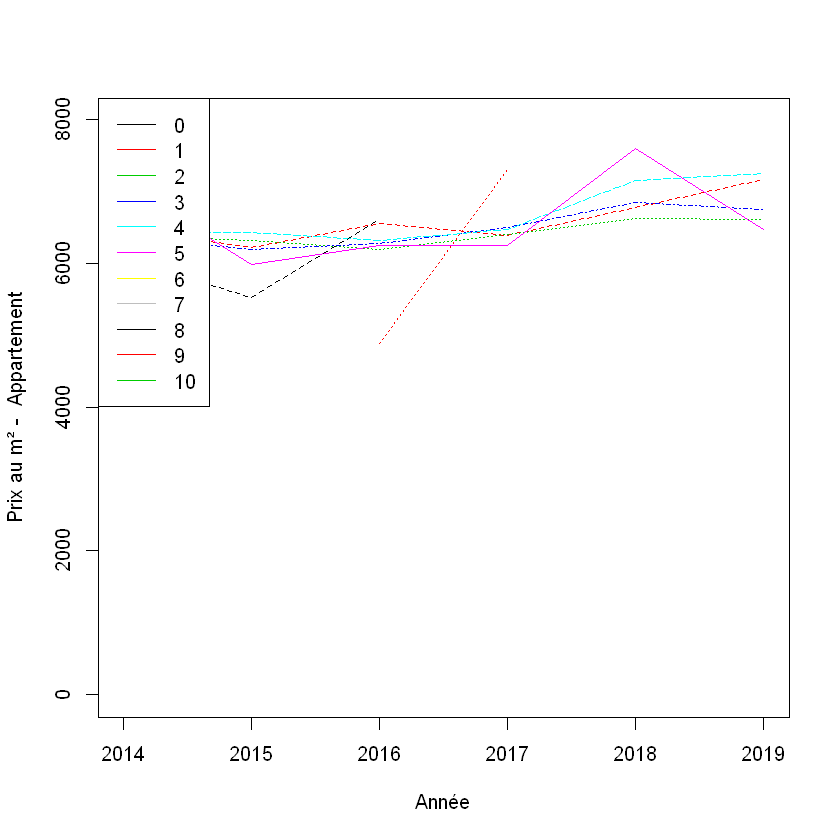

       0   1   2   3   4   5   6   7   8   9  10
2014 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2015 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2016 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2017 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2018 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2019 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN


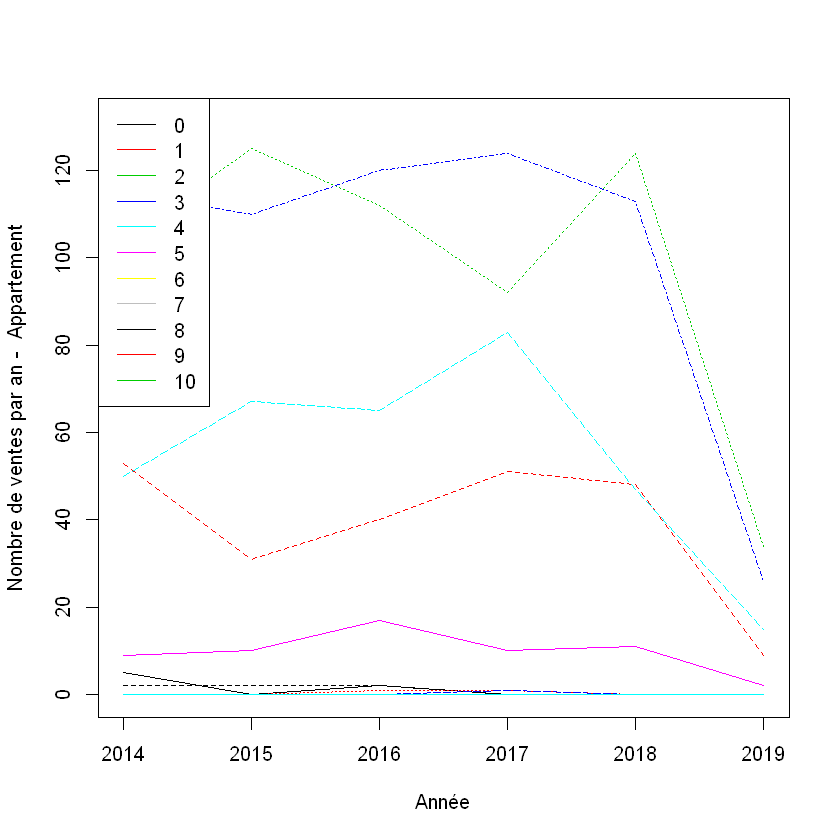

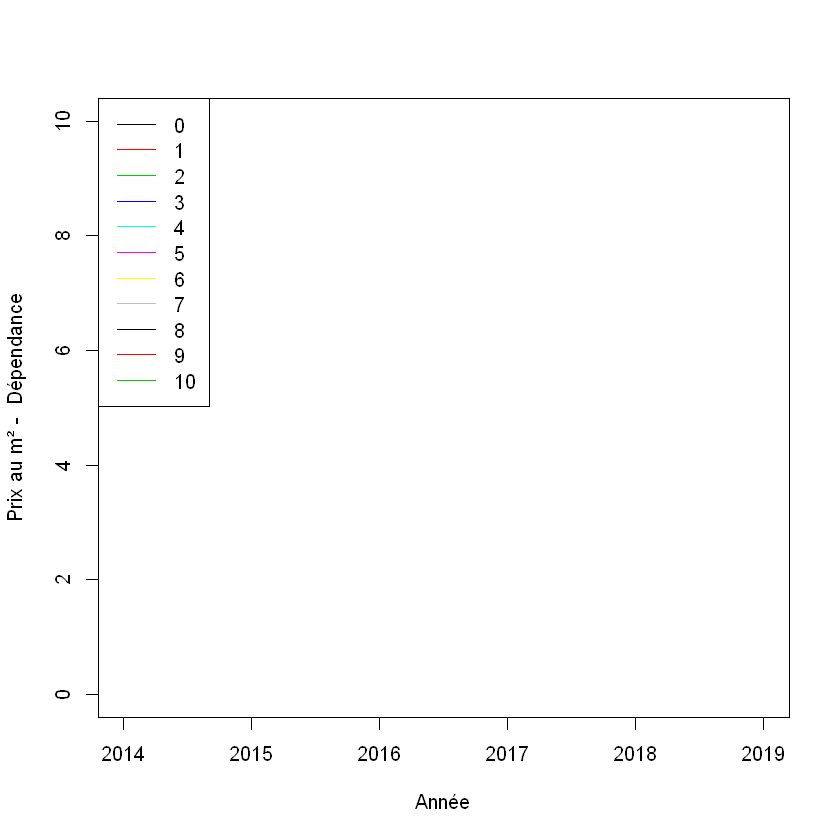

            0   1   2   3   4   5   6   7   8   9  10
2014 5373.239 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2015 5395.058 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2016 4679.477 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2017 6154.045 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2018 6505.269 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
2019 8326.392 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN


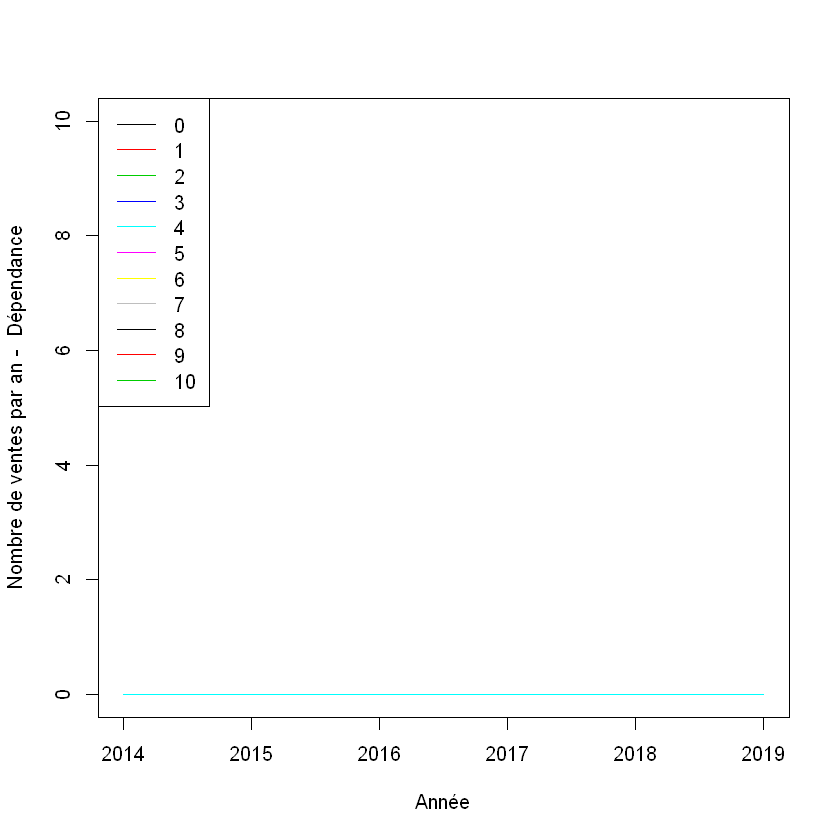

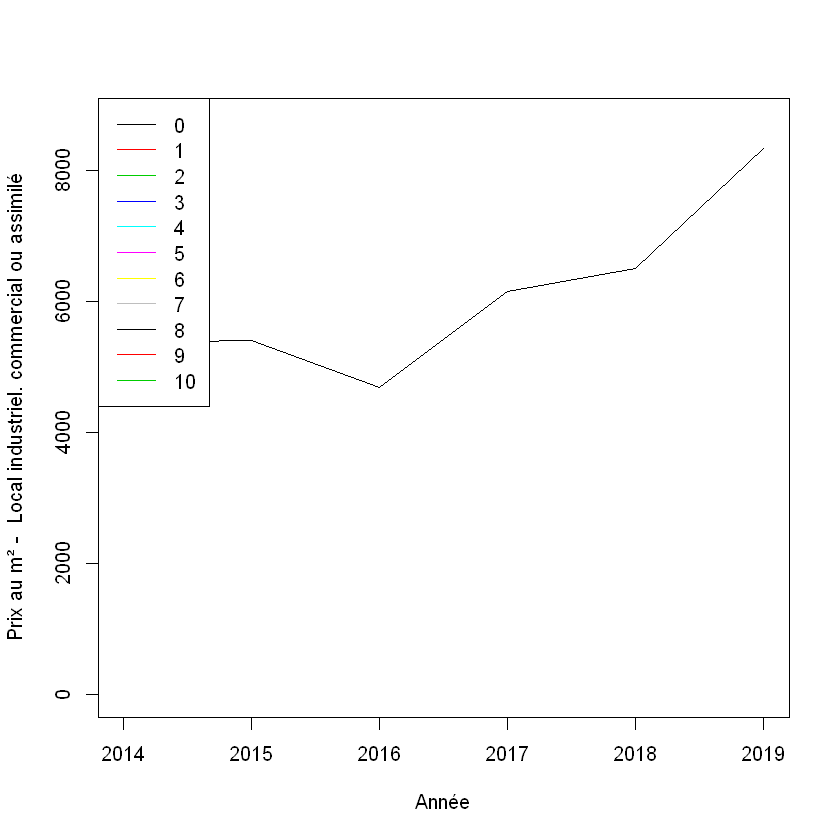

            0   1     2        3         4        5        6        7        8
2014      NaN NaN 10500 8069.207  8794.677 7548.347 8802.568      NaN 5909.836
2015 10959.38 NaN   NaN 6894.530  8077.162 8492.260 8061.338 6350.806 6531.496
2016      NaN NaN   NaN 7079.545  8103.231 6935.781 7989.130 6243.094      NaN
2017      NaN NaN   NaN 8806.382 10419.231 8165.893 8841.562 8357.623 7414.948
2018      NaN NaN   NaN 9749.232  7612.285 8925.000 9480.158 9395.307      NaN
2019      NaN NaN   NaN      NaN  9346.644 9970.690      NaN      NaN      NaN
       9       10
2014 NaN      NaN
2015 NaN      NaN
2016 NaN      NaN
2017 NaN      NaN
2018 NaN 5280.288
2019 NaN      NaN


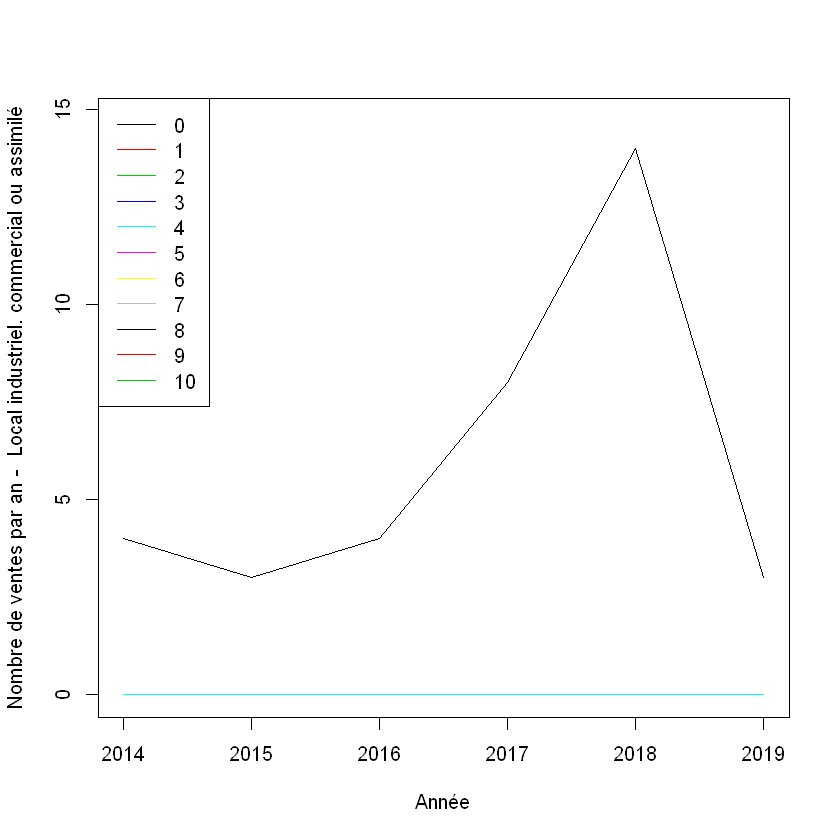

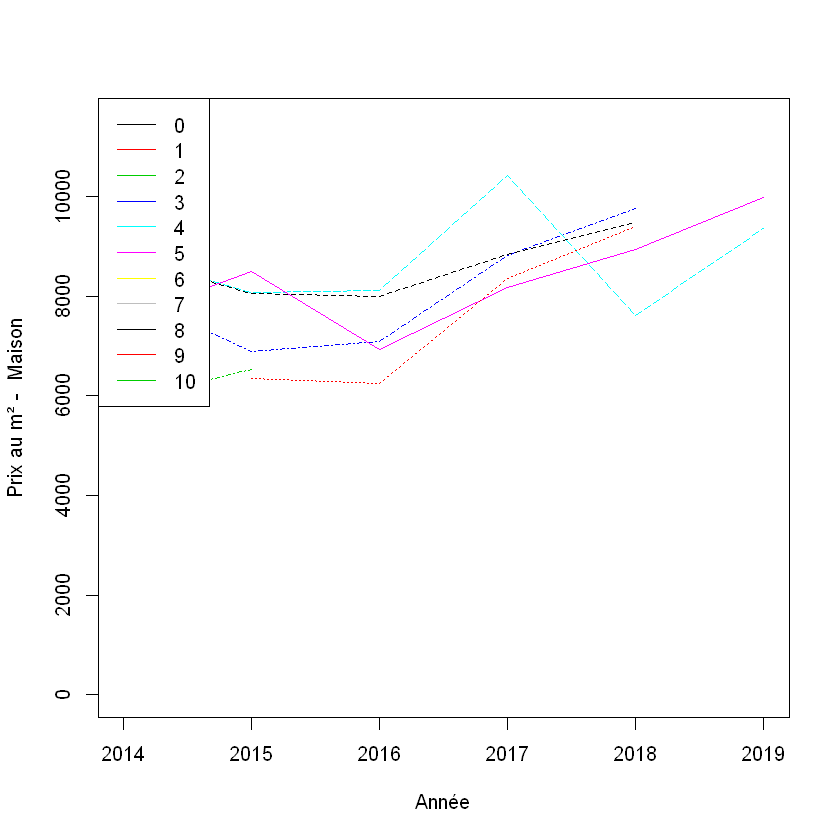

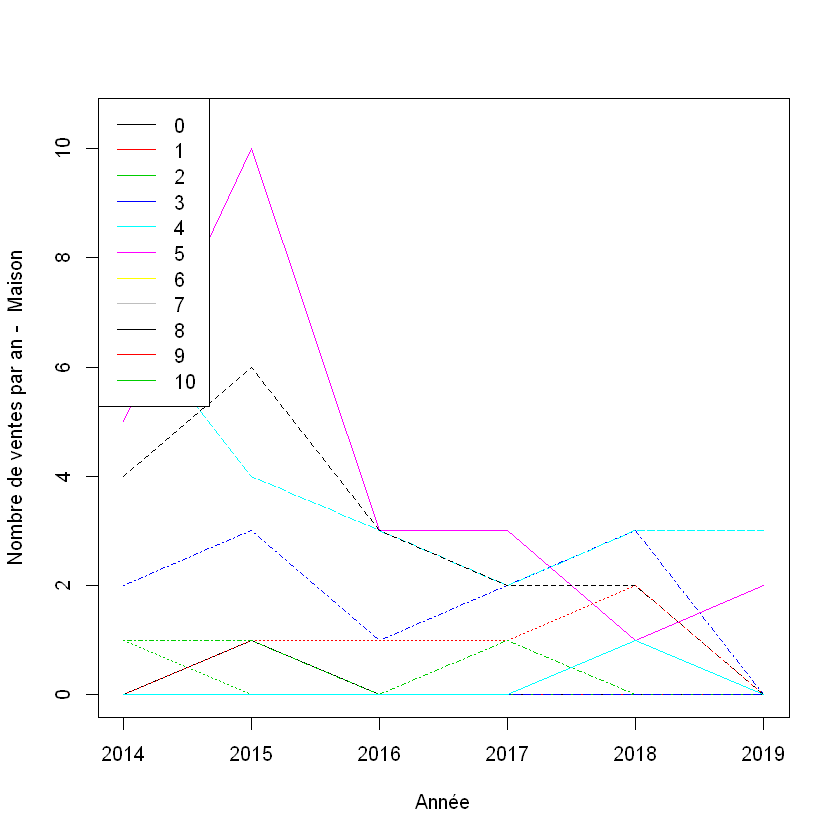

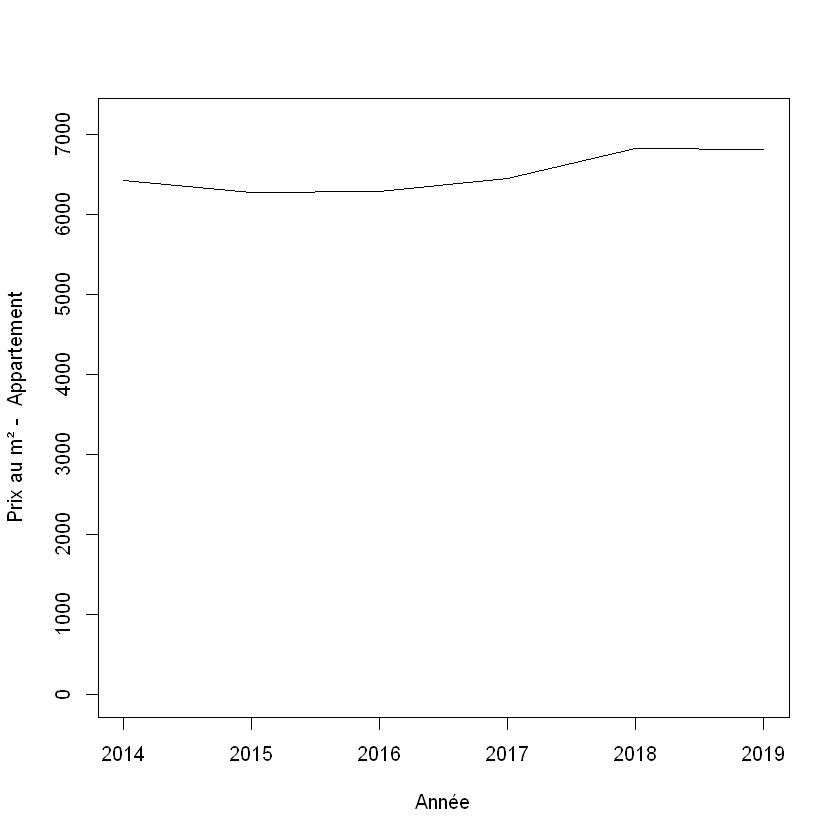

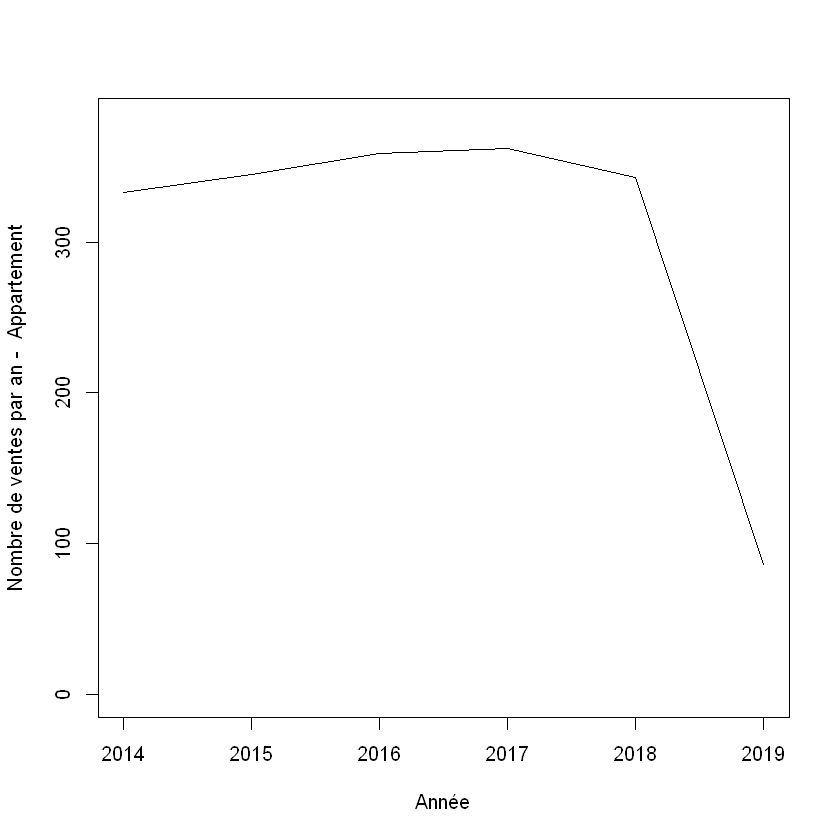

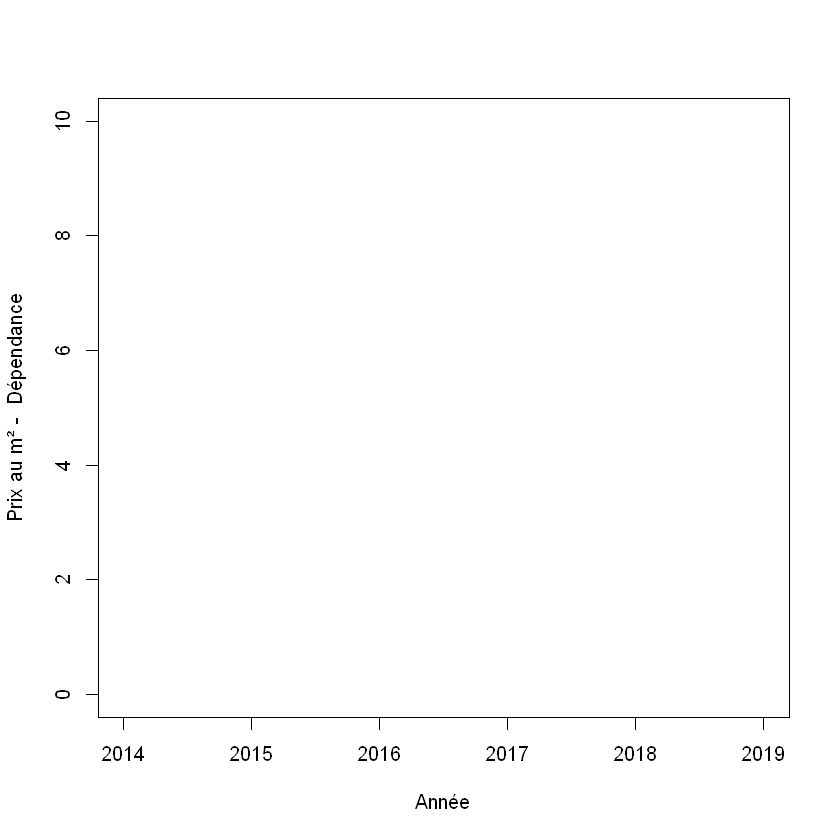

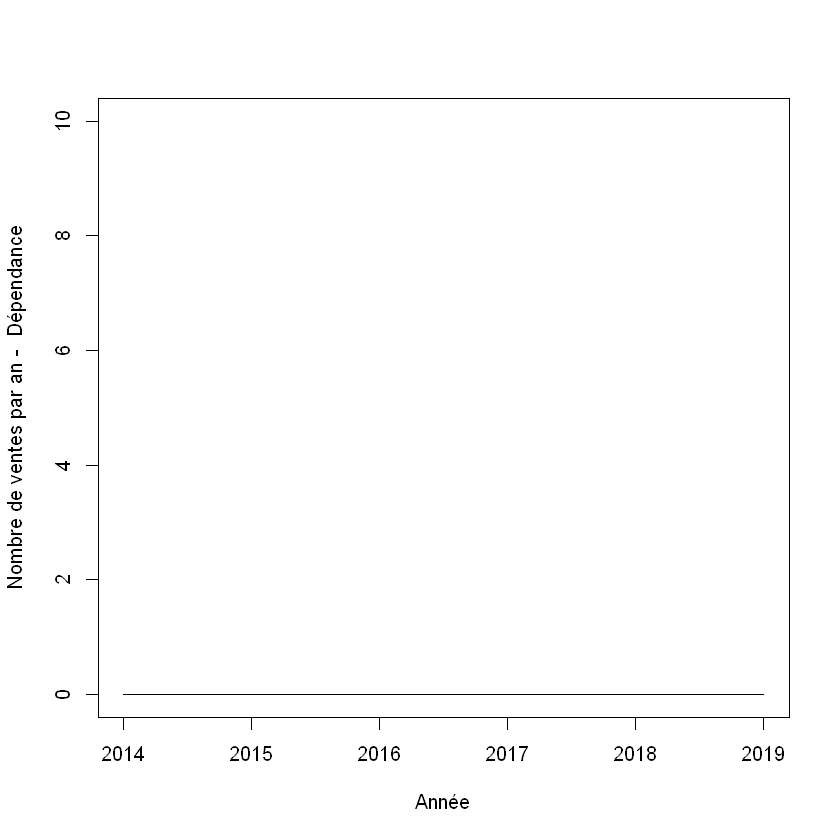

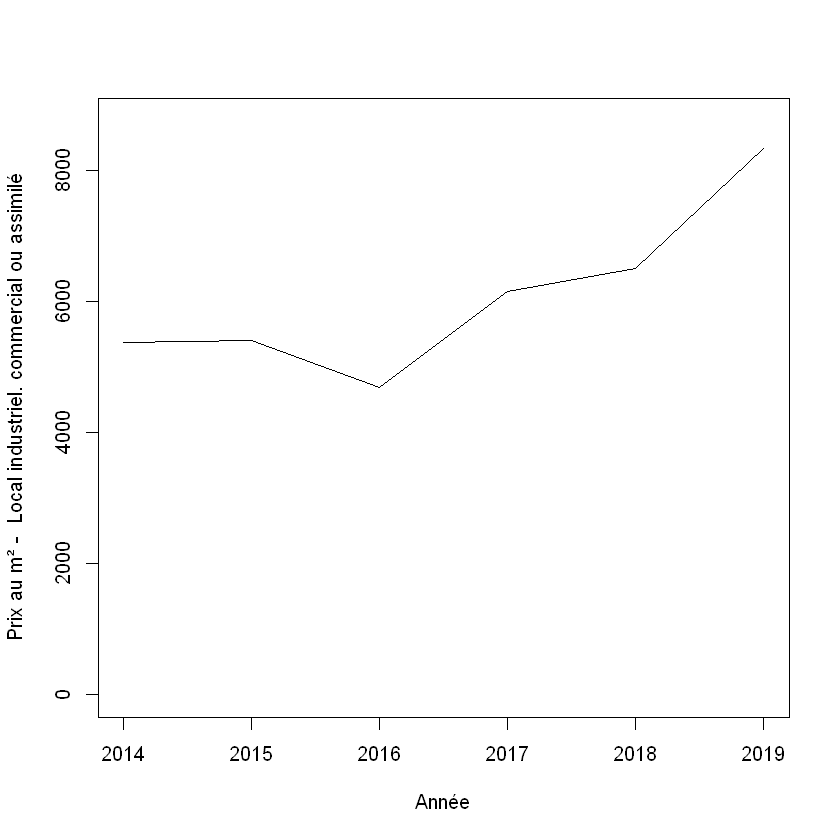

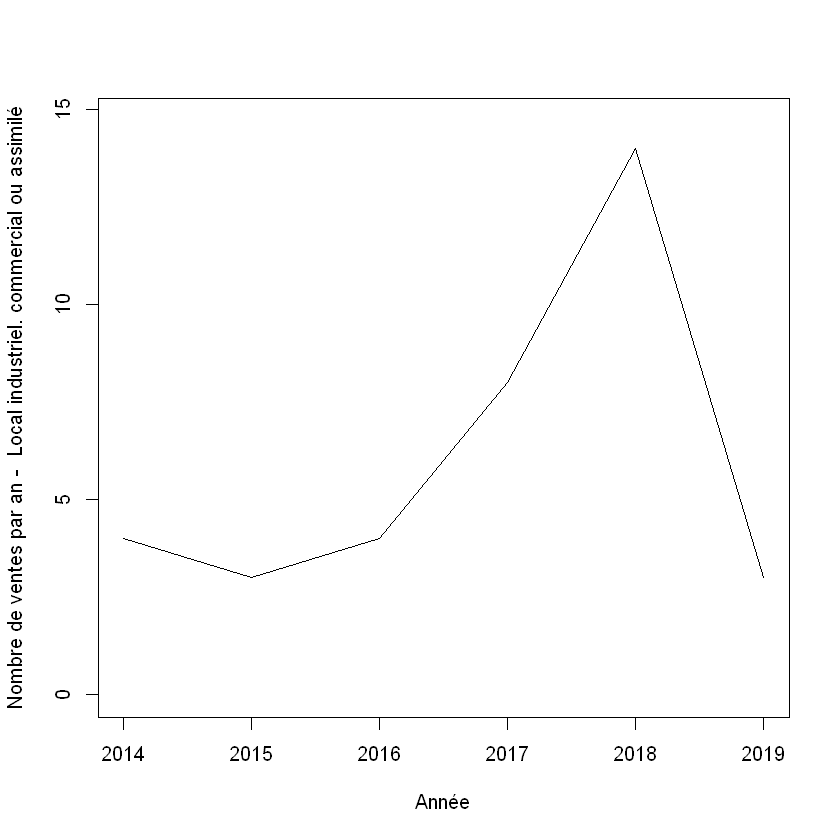

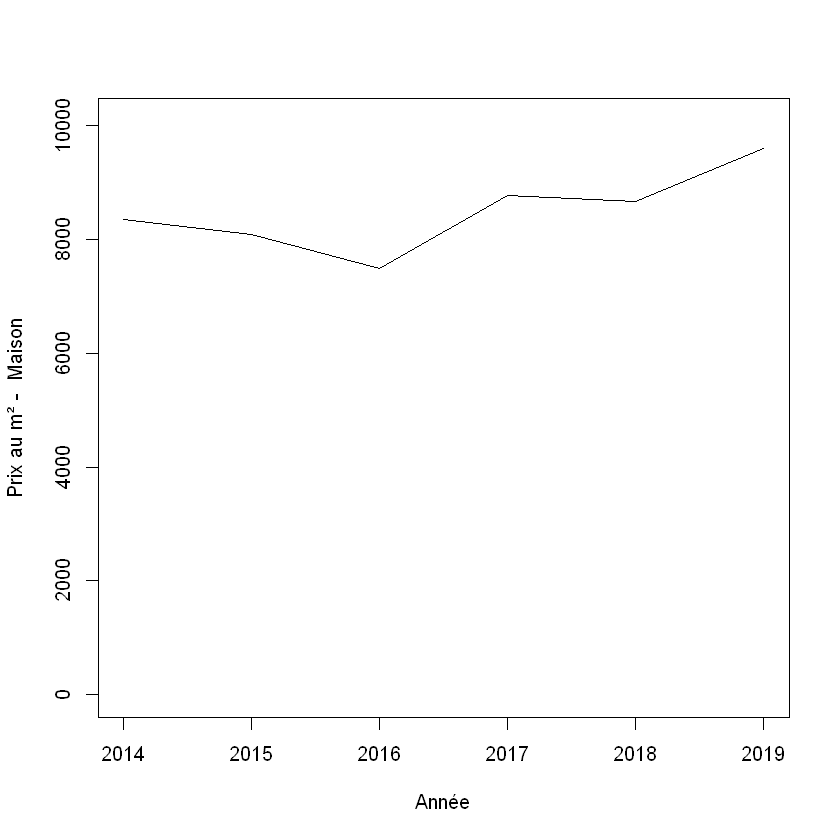

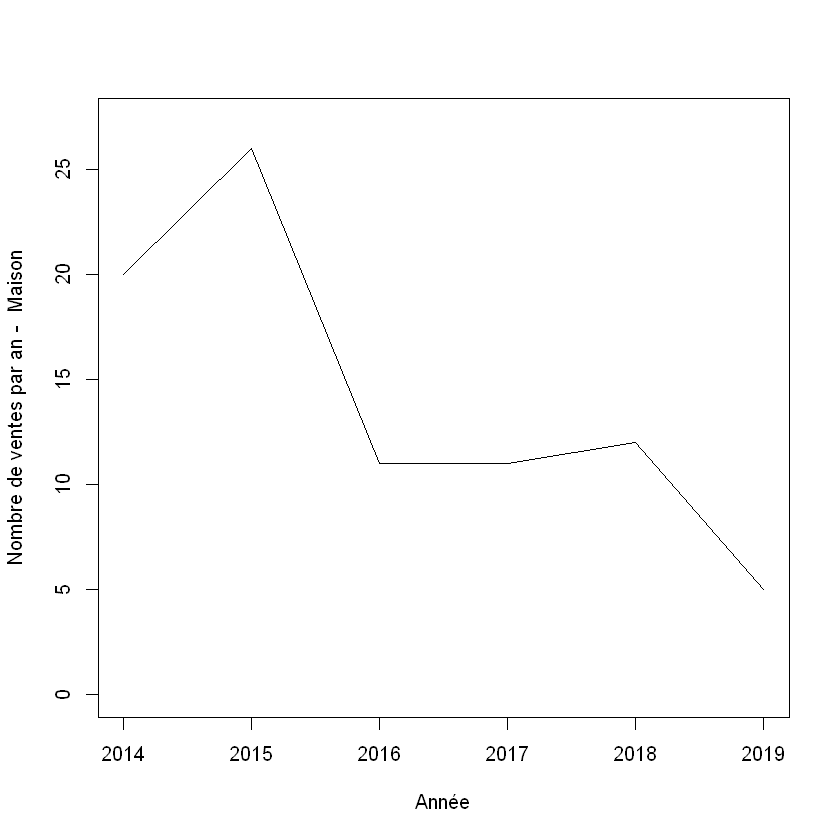

In [6]:


library(RJSONIO)
library(RCurl)
library("lubridate")
library(jsonlite)

frais=0.05

#Métro Nation
#Lat=48.849077
#Lon=2.398671
#Rayon=200

#7 place de la Flourie, 35400 Saint Malo
#Lat = 48.620613
#Lon = -2.009287
#Rayon = 400

#Gare de Becon
Lat = 48.906006
Lon = 2.268197
Rayon = 500

#Bérault métro
#Lat = 48.845392
#Lon = 2.429531
#Rayon = 700

#Vincennes
#Lat = 48.844779
#Lon = 2.437233
#Rayon = 700

#Saint mandé métro
#Lat = 48.846334
#Lon = 2.419169
#Rayon = 200


#La variable lien permet de construire la requete sur l'API DVF.
Lien = paste("http://api.cquest.org/dvf?lat=",
             Lat,
             "&lon=",
             Lon,
             "&dist=",
             Rayon,
             sep = "")
download.file(Lien, destfile = "dvf.json")

jdata <- fromJSON("dvf.json")
data <- as.data.frame(jdata)
write.csv(data$features.properties,
          file = "dvf.csv",
          row.names = TRUE)
donnees  	<- read.csv('dvf.csv', sep = ',', header = TRUE)
#A faire : optimiser le retraitement des données
#implémenter une fonction pour découper une vente d'immeuuble.
#Pourrait prendre la forme suivante : Une fonction de comparaison de deux vente dans une même df
#Puis, une boucle sur toutes les ventes avec deux indices i et j initilisé avec j=i+1
#a chaque pas, on compare les deux indices
#Tant qu'ils sont identiques on incrémente j et pas i
#Quand ils redeviennent différents et si i-j>1 : on moyenne les prix et reprend la boucle.
donnees=subset(donnees,type_local != "NA" )
donnees$valeur_fonciere=donnees$valeur_fonciere*(1+frais)
donnees=subset(donnees,valeur_fonciere/surface_relle_bati > 4000 )
donnees=subset(donnees,valeur_fonciere/surface_relle_bati < 12000 )
n_ventes = nrow(donnees)


donnees$date_mutation = as.Date(donnees$date_mutation, "%Y-%m-%d")




donnees$date_mutation = year(donnees$date_mutation)
write.csv(donnees,
          file = "dvf2.csv",
          row.names = TRUE)


Types    = levels(donnees$type_local)
Annees   = sort(unique(donnees$date_mutation))
Pieces = sort(unique(donnees$nombre_pieces_principales))

n_types  = length(Types)
n_annees = length(Annees)
n_pieces = length(Pieces)




#Construction de la df des résultats

#Alimentation de la df
#Pour chaque genre de logement (appart/dép/local), on calcule le prix moyen par année et par Type de logement (nombre de pieces).
#Un type de logement => une courbe de prix moyen.
#Pour chaque donnée, on extrait de la base brute les données qui correspondent au genre/Année/nb de pièces via subset
#Ensuite soit on initialise la première ligne 'pligne = True', soit on ajoute les données à la DF de résultats
pligne = TRUE
for (i in Types) {
  for (j in Annees) {
    for (k in Pieces) {
      sub_donnees = subset(
        donnees,
        type_local == as.character(i) &
          date_mutation == as.character(j) &
          nombre_pieces_principales == as.character(k),
        select = c("valeur_fonciere", "surface_relle_bati")
      )
      n_ventes = nrow(sub_donnees)
      prix_m2 = mean(sub_donnees$valeur_fonciere / sub_donnees$surface_relle_bati)
      if (pligne == TRUE) {
        df_prix_moy <- data.frame(matrix(ncol = 5, nrow = 1))
        colnames(df_prix_moy) <-
          c("Type",
            "Année",
            "Pièces",
            "Prix_moyen",
            "Nombre_ventes")
        df_prix_moy[1,] = c(i, j, k, prix_m2, n)
        print(df_prix_moy)
        pligne = FALSE
      } else{
        df_prix_moy = rbind(df_prix_moy, c(i, j, k, prix_m2, n_ventes))
      }
    }
  }
}

#Construction de la df des résultats
pligne = TRUE
#Alimentation de la df
#Pour chaque genre de logement (appart/dép/local), on calcule le prix moyen par année.
#Pour chaque donnée, on extrait de la base brute les données qui correspondent au genre/Année via subset
#Ensuite soit on initialise la première ligne 'pligne = True', soit on ajoute les données à la DF de résultats
for (i in Types) {
  for (j in Annees) {
    sub_donnees = subset(
      donnees,
      type_local == as.character(i) &
        date_mutation == as.character(j),
      select = c("valeur_fonciere", "surface_relle_bati")
    )
    n = nrow(sub_donnees)
    prix_m2 = mean(sub_donnees$valeur_fonciere / sub_donnees$surface_relle_bati)
    x = c(i, j, prix_m2, n)
    if (pligne == TRUE) {
      df_prix_moy2 <- data.frame(matrix(ncol = 4, nrow = 1))
      colnames(df_prix_moy2) <-
        c("Type", "Année", "Prix_moyen", "Nombre_ventes")
      df_prix_moy2[1,] = c(i, j, prix_m2, n)
      pligne = FALSE
    } else{
      df_prix_moy2 = rbind(df_prix_moy2, x)
    }
  }
}

#Construction des matrices de résulats
#Création des 4 matrices de résultats
#Deux matrices (a et b) pour les prix et le nombre de ventes par nombre de pièces
#Deux matrices (c et d) pour les prix et le nombre de ventes de manière indiférentiée du nombre de pièces
a = matrix (rep(0, n_annees * n_pieces), n_annees, n_pieces)
rownames(a) = Annees
colnames(a) = Pieces

b = matrix (rep(0, n_annees * n_pieces), n_annees, n_pieces)
rownames(b) = Annees
colnames(b) = Pieces

c = matrix (rep(0, n_annees * 1), n_annees, 1)
rownames(c) = Annees
colnames(c) = c("Global")

d = matrix (rep(0, n_annees * 1), n_annees, 1)
rownames(d) = Annees
colnames(d) = c("Global")



#Première boucle, pour chaque type de logement, pour chaque nombre de pièces et pour chaque année, affiche la courbe du nombre de ventes et du prix moyen.
#Les variables Prix_m2_an_max et Nb_ventes_max servent à dimentionner la taille des fenetres.

for (i in Types) {
  x = 1
  Prix_m2_an_max = 0
  Nb_ventes_max = 0
  for (j in Annees) {
    y = 1
    for (k in Pieces) {
      Prix_m2_an = as.numeric(
        subset(
          df_prix_moy,
          Type == as.character(i) &
            Année == as.character(j) &
            Pièces == as.character(k),
          select = c("Prix_moyen")
        )[[1]]
      )
      a[x, y] = Prix_m2_an
      if (is.finite(Prix_m2_an) & Prix_m2_an > Prix_m2_an_max) {
        Prix_m2_an_max = Prix_m2_an
      }
      Nb_ventes = as.numeric(
        subset(
          df_prix_moy,
          Type == as.character(i) &
            Année == as.character(j) &
            Pièces == as.character(k),
          select = c("Nombre_ventes")
        )[[1]]
      )
      b[x, y] = Nb_ventes
      if (is.finite(Nb_ventes) & Nb_ventes > Nb_ventes_max) {
        Nb_ventes_max = Nb_ventes
      }
      y = y + 1
    }
    x = x + 1
  }
  print(a)
  matplot(
    rownames(a),
    a,
    type = 'l',
    xlab = 'Année',
    ylab = paste('Prix au m² - ', i),
    ylim = c(0, max(10, Prix_m2_an_max * 1.05))
  )
  legend(
    'topleft',
    col = seq_len(ncol(a)),
    legend = colnames(a),
    lwd = 1
  )
  matplot(
    rownames(b),
    b,
    type = 'l',
    xlab = 'Année',
    ylab = paste('Nombre de ventes par an - ', i),
    ylim = c(0, max(10, Nb_ventes_max * 1.05))
  )
  legend(
    'topleft',
    col = seq_len(ncol(b)),
    legend = colnames(b),
    lwd = 1
  )
}

for (i in Types) {
  x = 1
  Prix_m2_an_max = 0
  Nb_ventes_max = 0
  for (j in Annees) {
    Prix_m2_an = as.numeric(subset(
      df_prix_moy2,
      Type == as.character(i) &
        Année == as.character(j),
      select = c("Prix_moyen")
    )[[1]])
    c[x, 1] = Prix_m2_an
    if (is.finite(Prix_m2_an) & Prix_m2_an > Prix_m2_an_max) {
      Prix_m2_an_max = Prix_m2_an
    }
    Nb_ventes = as.numeric(subset(
      df_prix_moy2,
      Type == as.character(i) &
        Année == as.character(j),
      select = c("Nombre_ventes")
    )[[1]])
    d[x, 1] = Nb_ventes
    if (is.finite(Nb_ventes) & Nb_ventes > Nb_ventes_max) {
      Nb_ventes_max = Nb_ventes
    }
    x = x + 1
  }
  matplot(
    rownames(c),
    c,
    type = 'l',
    xlab = 'Année',
    ylab = paste('Prix au m² - ', i),
    ylim = c(0, max(10, Prix_m2_an_max * 1.05))
  )
  matplot(
    rownames(d),
    d,
    type = 'l',
    xlab = 'Année',
    ylab = paste('Nombre de ventes par an - ', i),
    ylim = c(0, max(10, Nb_ventes_max * 1.05))
  )
}



